In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# from plotnine import * 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from synth_helpers import * 
import datetime
import os
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
from statsmodels.distributions.empirical_distribution import ECDF
import pickle
import copy
import scipy as sp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
incident_series = pd.read_csv('incident_series_update.csv')
cities = incident_series['city'].unique()
incident_series.fillna(0, inplace=True)
incident_series.category.unique()

array(['Property_Burglary', 'Property_Theft', 'Violent_Assault',
       'Violent_Homicide', 'Violent_Robbery', 'Drug_Drug',
       'Gambling_Gambling', 'Property_Arson',
       'Property_Other Property Crime', 'Property_White Collar',
       'Violent_Rape'], dtype=object)

In [6]:
city_pop = pd.read_csv('city-populations.csv')
treat_key = 'New York City'
excluded = ['New York City', 'Atlanta', 'Fort Worth' ]
excludes = ['Atlanta', 'Fort Worth' ]
original_ctrls = [x for x in cities if x not in excluded] 
# Add intercept
original_ctrls+= ['intercept']
ctrls=original_ctrls
cities_  = [x for x in cities if x not in excludes]  # Exclude Atlanta, Fort Worth 
print ctrls

cat = 'Violent_Assault'
start_date = '2018-01-01'
end_date = '2020-01-01'
start_2 = '2020-01-02'
lockdown = '2020-03-15'
end_2_date = '2020-03-15'

def reset_cities(incident_series,excluded, excludes): 
    cities = incident_series['city'].unique()
    original_ctrls = [x for x in cities if x not in excluded] 
    original_ctrls+= ['intercept']
    ctrls=original_ctrls
    cities_  = [x for x in cities if x not in excludes]  # Exclude Atlanta, Fort Worth 
    return [ctrls,cities_] 

['Austin', 'Baltimore', 'Boston', 'Buffalo', 'Chicago', 'Cincinnati', 'Dallas', 'Denver', 'Detroit', 'Houston', 'Kansas City', 'Little Rock', 'Los Angeles', 'Louisville', 'Milwaukee', 'Nashville', 'Philadelphia', 'Phoenix', 'Portland', 'Raleigh', 'San Francisco', 'Seattle', 'Virginia Beach', 'Washington DC', 'intercept']


## configurations

In [11]:
# Choose synthetic control method

# Linear regression with ridge: 
# method='linreg' 
# ridge = True 

# Linear regression with no penalty: 
# method='linreg' 
# ridge = False 

# RSC: 
method= 'RSC'
ridge = False


In [12]:
# Configure intervention times 
end_date_pre = '2019-08-01'
start_2_pre = '2019-08-02'
end_2_date_pre = '2020-01-01'

# Force nonnegative weights (True) or not (False)
nonneg=False


In [16]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

cats = ['Violent_Assault','Property_Theft','Property_Burglary','Violent_Robbery', 'Drug_Drug']
cats_print = ['Violent Assault','Property Theft','Property Burglary','Violent Robbery', 'Drug']
daily__ = [False, False, False, False,False,False ]
weekly_ = ['W','W','5W','5W','2W','3W']
placebo_mses_=[None]*len(cats)
sc_ctrls=[None]*len(cats)

ws = dict()
SC_mses = np.zeros(len(cats));Rsquareds = np.zeros(len(cats))
placebo_ate_p = np.zeros(len(cats));placebo_ate_nyc = np.zeros(len(cats));

# Placebos in time: artificially move intervention date earlier and set new test perid to be alt_end_time - alt_start2_time
alt_end_times = ['2019-01-01','2019-03-01','2019-06-01']
alt_start2_times = ['2019-01-02','2019-03-02','2019-06-02' ]
placebo_intime_ate_p = np.zeros([len(cats),len(alt_end_times)]);placebo_intime_ate_nyc = np.zeros([len(cats),len(alt_end_times)]);

# Robustness checks for early roll-in of invervention: new pre-test period until alt_start_times_rollin 
alt_end_times_rollin = ['2019-09-01','2019-10-01','2019-11-01' ]
alt_start2_times_rollin = ['2019-09-02','2019-10-02','2019-11-02' ]
placebo_rollin_ate_p = np.zeros([len(cats),len(alt_end_times)]);
placebo_rollin_ate_nyc = np.zeros([len(cats),len(alt_end_times)]);

# Parameters for visualization
horizon=1 # rolling time series average horizon (for visualization)
loess = True # smoothing by loess (for visualization)
loess_frac=0.07 # smoothing fraction for LOESS (for visualization)

# Configuration for RSC: singular value 
sv_selections = {
    'Property_Burglary':11, 
    'Property_Theft': 9, 
    'Violent_Assault': 5,
    'Violent_Homicide': 2, 
    'Violent_Robbery': 6, 
    'Drug_Drug': 4,
    'Gambling_Gambling': 2, 
    'Property_Arson': 3,
    'Property_Other Property Crime': 1, 
    'Property_White Collar': 2,
    'Violent_Rape': 3
}

# Configuration for ridge tuning
n_lda=100
lmbdas = np.logspace(-8, -2, num=n_lda)
ws_lmbda = [None] * n_lda;mses = np.zeros(n_lda)

# Threshold on ratio of placebo MSEs 
placebo_mse_thresh=7.5
# daily_='daily' if daily else 'weekly'


In [17]:
# Initialize 
placebo_intime_mses_=[None]*len(cats)
placebo_rollin_mses_=[None]*len(cats)
n_placebos_ = np.zeros(len(cats))
nyc_means = np.zeros(len(cats))

# alternative mse-based test statistic
placebo_mse_ratios_=[None]*len(cats)
placebo_intime_mse_ratios_=[None]*len(cats)
placebo_rollin_mse_ratios_=[None]*len(cats)
placebo_mse_ratio_p = np.zeros(len(cats));placebo_mse_ratio_nyc = np.zeros(len(cats));
placebo_intime_mse_ratio_p = np.zeros([len(cats),len(alt_end_times)]); 
placebo_rollin_mse_ratio_p = np.zeros([len(cats),len(alt_end_times)])
placebo_intime_mse_ratio_nyc = np.zeros([len(cats),len(alt_end_times)]); 
placebo_rollin_mse_ratio_nyc = np.zeros([len(cats),len(alt_end_times)])

# Check parameters for ridge
Choose range of parameters so that the optimal penalty is in the interior of the range

In [18]:
# for ind,cat in enumerate(cats): 
    
#     [trainDF,testDF, series, cities, means] = get_data_dicts(
#         incident_series,cat, treat_key, ctrls, cities_, start_date, end_date, 
#         start_2, end_2_date,city_pop,daily=daily__[ind],weekly_agg=weekly_[ind])
#     nyc_means[ind] = means['New York City']
#     ctrls = [x for x in original_ctrls if (x in cities) ] # drop unsupported cities from controls
#     lockdown = '2020-03-15'
#     if daily__[ind]:
#         yearsToPlot = series[start_date:end_2_date].index
#     else: 
#         yearsToPlot=series[start_date:end_2_date].index
#     # linear reg
#     sc_ctrls_ = ctrls + ['intercept']
#     w = SC(treat_key, sc_ctrls_, trainDF,nonneg=nonneg); 
#     print w 
#     sc_ctrls[ind] = [col for col in trainDF[sc_ctrls_].columns]
#     print sc_ctrls[ind]
#     ws[ind]=w.flatten()
# #     print [(ctrls[i], np.round(np.asscalar(w[i]),3)) for i in range(len(ctrls))]
#     sc_pre = np.matmul(trainDF[sc_ctrls_].values, w)
#     predictions = np.matmul(testDF[sc_ctrls_].values, w)
    
#     # reload data dicts for hyperparameter validation 
#     [trainDF_pre,testDF_pre, series_pre, cities_pre, means_pre] = get_data_dicts(
#         incident_series,cat, treat_key, ctrls, cities_, start_date, end_date_pre, 
#         start_2_pre, end_2_date_pre,city_pop,daily=daily__[ind],weekly_agg=weekly_[ind])
    
#     # ridge penalty
#     for lmbda_ind,lmbda in enumerate(lmbdas): 
#             # linear reg
#         sc_ctrls_ = ctrls + ['intercept']
#         w = SC_ridge(treat_key, sc_ctrls_, trainDF_pre, lmbda,nonneg=nonneg); 
#         ws_lmbda[lmbda_ind]=w.flatten()
#         predictions = np.matmul(testDF_pre[sc_ctrls_].values, w)
#         mses[lmbda_ind] = np.sqrt(np.mean(np.square(testDF_pre[treat_key].values - predictions.flatten())))
#     best_lmbda = lmbdas[np.argmin(mses)] 
#     w_ridge = ws_lmbda[np.argmin(mses)]
#     print 'ridge w', w_ridge
#     print 'best_lbmda', best_lmbda
#     print 'best mse', mses[np.argmin(mses)]
#     print 'mses', mses

# Run synthetic control and generate outputs 

('testmse', 1.7201787386185807e-05)
('trainmse', 8.205380696478873e-06)
8.205380696478873e-06
ratios, [2.59502182 2.79342724 3.63460616 2.35887866 1.71227556 3.55059613
 1.0948242  2.57930505 0.84507426 4.0935878  4.46686834 1.73449714
 1.08877634 0.42824447 3.28736972 3.05631706 4.13672151 3.10338066
 1.23774459 1.20881175 2.86890674 4.00647648 2.6002796  3.04338501]


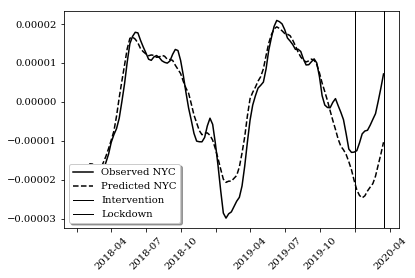

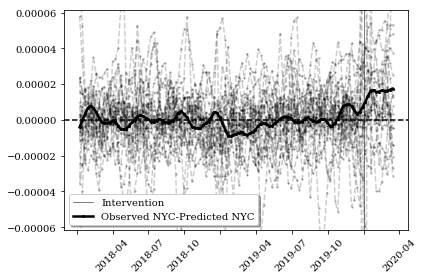

0.6000000000000001
0.24000000000000002
('placebo ate p', 0.64)
('placebo mse p', 0.7916666666666667)
computing Placebos in time  
intime placebos
0.36
0.44
('timeplacebo', '2019-01-01', ', placebo ate p, ', 0.36)
('placebo mse p', 0.08333333333333334)
intime placebos


/opt/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.39999999999999997
0.52
('timeplacebo', '2019-03-01', ', placebo ate p, ', 0.44)
('placebo mse p', 0.2916666666666667)
intime placebos
0.39999999999999997
0.48
('timeplacebo', '2019-06-01', ', placebo ate p, ', 0.52)
('placebo mse p', 0.625)
intime placebos
0.39999999999999997
0.39999999999999997
('timeplacebo---early roll-in of intervention', '2019-09-01', ', placebo ate p, ', 0.6000000000000001)
('placebo_mse_ratios', array([  0.97817852,   1.20530621,   1.49432203,   1.00787919,
         1.47541996,   0.67973312,   1.10410831,   0.99392393,
         0.76751165,   1.17160854,   1.14046862,  22.99776716,
       178.72363302,   3.79112012,   1.08452389,   1.4173151 ,
         1.20847964,  24.84315073,  38.9598757 ,   3.02838768,
         1.64223247,   1.66370774,   1.05934973,   0.97855218]))
('placebo mse p', 0.75)
intime placebos
0.48
0.48
('timeplacebo---early roll-in of intervention', '2019-10-01', ', placebo ate p, ', 0.64)
('placebo_mse_ratios', array([ 0.91566156,  1.02923107, 

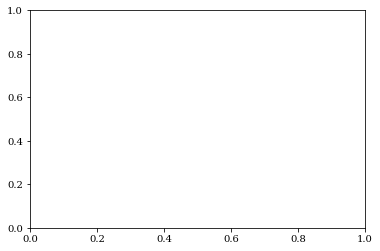

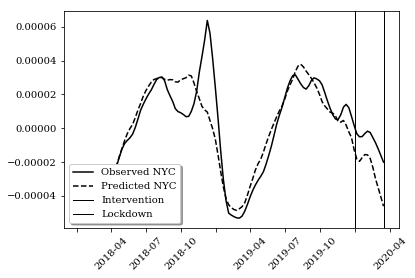

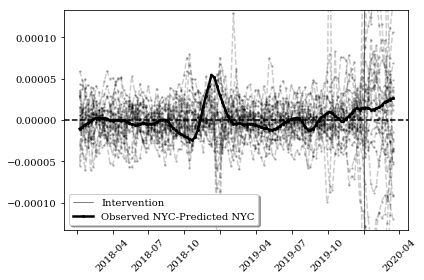

0.44
0.39999999999999997
('placebo ate p', 0.56)
('placebo mse p', 0.20833333333333334)
computing Placebos in time  
intime placebos
0.32
0.52
('timeplacebo', '2019-01-01', ', placebo ate p, ', 0.24000000000000002)
('placebo mse p', 0.37500000000000006)
intime placebos
0.16
0.52
('timeplacebo', '2019-03-01', ', placebo ate p, ', 0.24000000000000002)
('placebo mse p', 0.37500000000000006)
intime placebos
0.36
0.68
('timeplacebo', '2019-06-01', ', placebo ate p, ', 0.39999999999999997)
('placebo mse p', 0.0)
intime placebos
0.56
0.48
('timeplacebo---early roll-in of intervention', '2019-09-01', ', placebo ate p, ', 0.6000000000000001)
('placebo_mse_ratios', array([ 1.32178935,  2.61592423,  2.46548899,  1.41386298,  3.63837486,
        5.49993556, 16.72614325,  1.58069886,  1.03960323,  3.77282463,
        1.51873566, 40.88732418, 42.84219557,  3.14930327,  1.70291903,
        5.13411359,  3.90059317,  2.01187089, 48.13675426,  1.32578611,
        1.7330991 ,  1.41973674,  5.71639442,  4

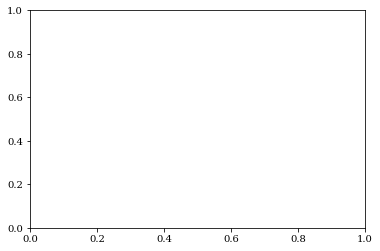

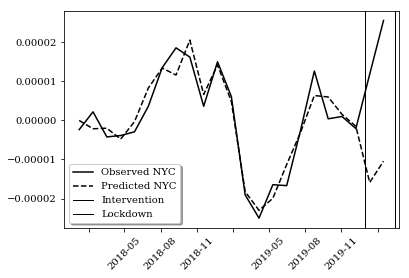

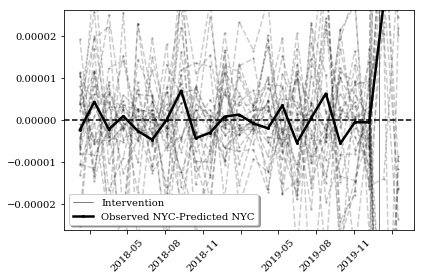

0.56
0.39999999999999997
('placebo ate p', 0.64)
('placebo mse p', 0.625)
computing Placebos in time  
intime placebos
0.39999999999999997
0.56
('timeplacebo', '2019-01-01', ', placebo ate p, ', 0.64)
('placebo mse p', 0.37500000000000006)
intime placebos
0.48
0.64
('timeplacebo', '2019-03-01', ', placebo ate p, ', 0.56)
('placebo mse p', 0.5416666666666666)
intime placebos
0.48
0.56
('timeplacebo', '2019-06-01', ', placebo ate p, ', 0.6000000000000001)
('placebo mse p', 0.5416666666666666)
intime placebos
0.44
0.44
('timeplacebo---early roll-in of intervention', '2019-09-01', ', placebo ate p, ', 0.6000000000000001)
('placebo_mse_ratios', array([ 1.5869843 ,  1.57733846,  1.80327892,  1.88548625,  4.47926537,
        1.25055673,  1.65006395,  1.70122311, 43.89687268,  2.98059574,
        0.98466437, 36.89002997, 77.79979384, 13.55097541,  1.97677656,
       31.85298558, 15.57518691,  1.5449269 , 58.52273976,  1.45127695,
        1.0505849 ,  9.71766854,  2.67163337, 15.2745162 ]))
('p

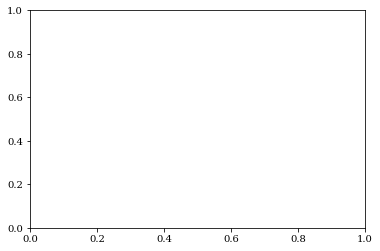

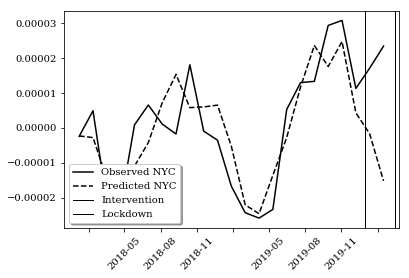

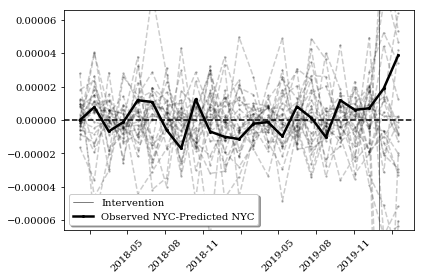

0.8
0.8
('placebo ate p', 0.8)
('placebo mse p', 0.7916666666666667)
computing Placebos in time  
intime placebos
0.32
0.6000000000000001
('timeplacebo', '2019-01-01', ', placebo ate p, ', 0.8)
('placebo mse p', 0.7083333333333334)
intime placebos
0.39999999999999997
0.56
('timeplacebo', '2019-03-01', ', placebo ate p, ', 0.8)
('placebo mse p', 0.7083333333333334)
intime placebos
0.64
0.52
('timeplacebo', '2019-06-01', ', placebo ate p, ', 0.8400000000000001)
('placebo mse p', 0.75)
intime placebos
0.8
0.36
('timeplacebo---early roll-in of intervention', '2019-09-01', ', placebo ate p, ', 0.8)
('placebo_mse_ratios', array([  2.8069096 ,   1.15441365,   1.58974035,   1.0671843 ,
         1.19293977,   1.16960449,   1.60042164,   1.03984324,
        11.21398435,   1.22356377,   1.08286071,   1.85813484,
       110.55398973,   1.16842106,   1.09717153,   3.78399655,
        38.75067351,   1.72625238, 280.12716584,   1.13568489,
         1.3706525 ,   1.72606717,   1.05282758,   1.13381542

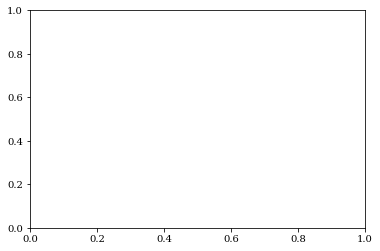

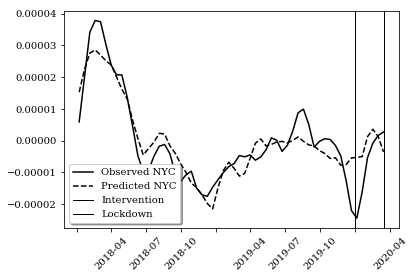

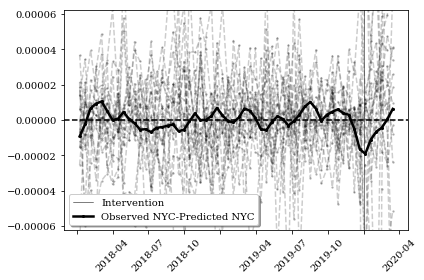

0.4736842105263158
0.631578947368421
('placebo ate p', 0.31578947368421056)
('placebo mse p', 0.1111111111111111)
computing Placebos in time  
intime placebos
0.631578947368421
0.368421052631579
('timeplacebo', '2019-01-01', ', placebo ate p, ', 0.631578947368421)
('placebo mse p', 0.6111111111111112)
intime placebos
0.4736842105263158
0.26315789473684215
('timeplacebo', '2019-03-01', ', placebo ate p, ', 0.5789473684210527)
('placebo mse p', 0.33333333333333337)
intime placebos
0.5263157894736843
0.4210526315789474
('timeplacebo', '2019-06-01', ', placebo ate p, ', 0.6842105263157896)
('placebo mse p', 0.33333333333333337)
intime placebos
0.8421052631578947
0.736842105263158
('timeplacebo---early roll-in of intervention', '2019-09-01', ', placebo ate p, ', 0.736842105263158)
('placebo_mse_ratios', array([ 1.31801985,  0.97220436,  1.1698848 ,  3.04643661,  3.00162796,
        1.34550553,  1.20923936, 30.5645826 , 54.2295852 ,  0.98265968,
        0.81139842,  0.43470752,  0.90238947, 

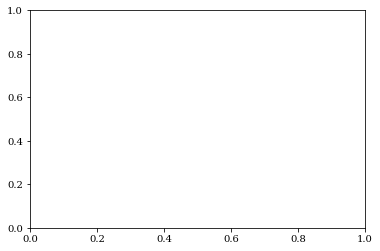

In [21]:
best_lmbdas = np.zeros(len(cats))
n_lda=100
lmbdas = np.logspace(-12, -2, num=n_lda)
ws_lmbda = [None] * n_lda;mses = np.zeros(n_lda)
plt.rcParams["font.family"] = "serif"
real_plt_color='black'    

ridge_name='ridge' if ridge else 'noridge'

for ind,cat in enumerate(cats): 
    daily = daily__[ind]
    [trainDF,testDF, series, cities, means] = get_data_dicts(
        incident_series,cat, treat_key, ctrls, cities_, start_date, end_date, 
        start_2, end_2_date,city_pop,daily=daily__[ind],weekly_agg=weekly_[ind])
    nyc_means[ind] = means['New York City']
    ctrls = [x for x in original_ctrls if (x in cities) ] # drop unsupported cities from controls
    lockdown = '2020-03-15'
    if daily:
        yearsToPlot = series[start_date:end_2_date].index
    else: 
        yearsToPlot=series[start_date:end_2_date].index

    
    if method=='linreg':
        sc_ctrls_ = ctrls + ['intercept']
        # Hyperparameter turning for ridge regression 
        if ridge: # ridge penalty
            print 'ridge'
            # reload data dicts for hyperparameter validation 
            [trainDF_pre,testDF_pre, series_pre, cities_pre, means_pre] = get_data_dicts(
                incident_series,cat, treat_key, ctrls, cities_, start_date, end_date_pre, 
                start_2_pre, end_2_date_pre,city_pop,daily=daily__[ind],weekly_agg=weekly_[ind])
            ridge_params = [trainDF_pre, testDF_pre, lmbdas]
            for lmbda_ind,lmbda in enumerate(lmbdas): 
                    # linear reg
                sc_ctrls_ = ctrls + ['intercept']
                w = SC_ridge(treat_key, sc_ctrls_, trainDF_pre, lmbda,nonneg=nonneg); 
                ws_lmbda[lmbda_ind]=w.flatten()
                predictions = np.matmul(testDF_pre[sc_ctrls_].values, w)
                mses[lmbda_ind] = np.sqrt(np.mean(np.square(testDF_pre[treat_key].values - predictions.flatten())))
            best_lmbda = lmbdas[np.argmin(mses)] 
            w_ridge = ws_lmbda[np.argmin(mses)]
            w = w_ridge 
            best_lmbdas[ind] = best_lmbda
        else: 
            w = SC(treat_key, sc_ctrls_, trainDF,nonneg=nonneg); 
        print 'w', w
        sc_ctrls[ind] = [col for col in trainDF[sc_ctrls_].columns]
        print sc_ctrls[ind]
        ws[ind]=w.flatten()
    #     print [(ctrls[i], np.round(np.asscalar(w[i]),3)) for i in range(len(ctrls))]
        sc_pre = np.matmul(trainDF[sc_ctrls_].values, w)
        predictions = np.matmul(testDF[sc_ctrls_].values, w)

    
    elif method =='RSC': 
        singvals = sv_selections[cat]
        [denoisedDF, predictions] = run_RSC(singvals, trainDF, testDF, treat_key, ctrls)
        sc_pre = denoisedDF[treat_key].values
    
    real_nyc = np.append(trainDF[treat_key], testDF[treat_key], axis=0); 
    predicted = np.append(sc_pre, predictions, axis=0)
    sc_pre=sc_pre.flatten()
    SC_mse = np.sqrt(np.mean(np.square(trainDF[treat_key] - sc_pre)))
    
    # test_mse / train_mse 
    print('testmse', mse_( testDF[treat_key].values, predictions ))
    print('trainmse', mse_(trainDF[treat_key].values, sc_pre))
    SC_mse_ratio = mse_( testDF[treat_key].values, predictions ) / mse_(trainDF[treat_key].values, sc_pre)
    SC_mses[ind] = SC_mse
    Rsquareds[ind] = 1 - ((np.square(trainDF[treat_key].values - sc_pre)).sum() /np.square(trainDF[treat_key].values).sum())
    print SC_mse
    plt.figure();plt.tight_layout()
    ax=plt.gca()
    # Plot main SC comparison
#     plt.plot_date(yearsToPlot, real_nyc, color='red', label='observed NYC',ls='solid',markersize=2);
#     plt.plot_date(yearsToPlot, predicted, color='blue', label='predicted NYC',ls='solid',markersize=2);plt.axvline(x=end_date, linewidth=1, color='black', label='Intervention');plt.axvline(x=lockdown, linewidth=1, color='black', label='lockdown')
    data = pd.DataFrame(real_nyc,columns=['real_nyc'])
    data['years']=yearsToPlot;data.set_index('years')
    if loess: 
        loess_predicted=sm.nonparametric.lowess(predicted.flatten(), range(len(yearsToPlot)),return_sorted=False,frac=loess_frac)
        data['synth_nyc'] = loess_predicted
        loess_predicted=sm.nonparametric.lowess(real_nyc, range(len(yearsToPlot)),return_sorted=False,frac=loess_frac)
        data['real_nyc'] = loess_predicted
    else: 
        data['synth_nyc'] = predicted
    plt.plot_date(yearsToPlot, data['real_nyc'].rolling(horizon).sum(), color=real_plt_color, 
                  label='Observed NYC',ls='solid',markersize=0);
    plt.plot_date(yearsToPlot, data['synth_nyc'].rolling(horizon).sum(), 
                  color='black', label='Predicted NYC',ls='--',markersize=0);plt.axvline(x=end_date, linewidth=1, color='black', label='Intervention');plt.axvline(x=lockdown, linewidth=1, color='black', label='Lockdown')
    plt.setp(ax.get_xticklabels()[::4], visible=False)
    plt.xticks(rotation=45)
    legend = plt.legend(loc='lower left', shadow=True); 
#     plt.title('Synthetic control NYC ('+daily_+' agg), '+cats_print[ind]); 
    if loess: 
        plt.savefig('figs/synthcontrol_'+cat+'_'+method+ '_loess_'+ ridge_name+ '.pdf',bbox_inches='tight')
    else: 
        plt.savefig('figs/synthcontrol_'+cat+'_'+method+ ridge_name+'.pdf',bbox_inches='tight')
    pickle.dump(ax, open('figs/synthcontrol_'+cat+'_'+method+'.pkl', 'w'))

    og_treat_key = 'New York City' 
    excluded_cities = ['Atlanta', 'Fort Worth', 'intercept']
    exclude_og = [og_treat_key] + excluded_cities
    [nyres, nyparam] = lm_res(predictions.flatten(),testDF,treat_key)
#     residual_params = {}
#     residual_params[og_treat_key] = [nyres,nyparam]
#     placebo_ates = {}
#     placebo checks
    og_treat_key = 'New York City'
    not_nyc = [x for x in cities if x not in exclude_og] 
    [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
    cities_ = [x for x in cities if x not in excluded_cities]
    figname = 'synthcontrol_placebo_'+method+'-treated-'+treat_key+'_'+cat+'_'+ridge_name
    
    
    
    if method=='linreg':
        plt.figure()
        [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] =get_placebo_checks(\
            residual_params,placebo_ates,not_nyc, cities_, trainDF, testDF, yearsToPlot, 
            end_date, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,ridge=ridge,ridge_params=ridge_params)
        plt.plot_date(yearsToPlot, data['real_nyc'].rolling(horizon).sum()-data['synth_nyc'].rolling(horizon).sum(),
                      color='black', label='Observed NYC-Predicted NYC',ls='solid',markersize=2);
        print 'ratios,', placebo_mses/SC_mse
        keep = np.where(placebo_mses/SC_mse < placebo_mse_thresh )[0]
        filter_cities = [  not_nyc[ind_] for ind_ in keep ]
        filter_cities_ = filter_cities+['New York City']
        # filter based on mse ratio to synth control 
        [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
        ax = plt.gca();plt.setp(ax.get_xticklabels()[::4], visible=False);plt.xticks(rotation=45); 
        legend = plt.legend(loc='lower left', shadow=True); 
        plt.tight_layout();plt.savefig('synthcontrol_placebo_zoom_out'+method+'-treated-'+treat_key+'_'+cat+'.pdf',bbox_to_inches='tight')

        # plot 
        plt.figure()
        [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(\
            residual_params,placebo_ates,filter_cities, filter_cities_, trainDF, testDF, yearsToPlot, 
            end_date, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False)
        plt.axhline(0,color='black',ls='--'); plt.axvline(x=end_date, linewidth=0.5, color='black', label='Intervention')
        plt.plot_date(yearsToPlot, data['real_nyc'].rolling(horizon).sum()-data['synth_nyc'].rolling(horizon).sum(),
                      color='black', label='Observed NYC-Predicted NYC',ls='solid',linewidth=2.5,markersize=2);
        cities_ = filter_cities_
        not_nyc = filter_cities
        print 'n placebo', len(cities_)
        n_placebos_[ind] = len(cities_)
        ax = plt.gca();plt.setp(ax.get_xticklabels()[::4], visible=False);plt.xticks(rotation=45); 
        legend = plt.legend(loc='lower left', shadow=True); 
#         plt.ylim((-placebo_mse_thresh*SC_mse,placebo_mse_thresh*SC_mse) )
    #     plt.show()
        plt.tight_layout();
        plt.savefig(figname+'.pdf',bbox_to_inches='tight')
        pickle.dump(ax, open(figname+'.pkl','w'))
        plt.show();plt.close()
        
    elif method=='RSC':
        plt.figure()
        [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(\
            residual_params,placebo_ates,not_nyc, cities_, trainDF, testDF, yearsToPlot, end_date, lockdown,
            overplot=True, loess=loess, cat=cat,singvals=singvals,method=method,nonneg=False,save=False)
        plt.ylim((-placebo_mse_thresh*SC_mse,placebo_mse_thresh*SC_mse) )
        print 'ratios,', placebo_mses/SC_mse
        keep = np.where(placebo_mses/SC_mse < placebo_mse_thresh )[0]
        filter_cities = [  not_nyc[ind_] for ind_ in keep ]
        filter_cities_ = filter_cities+['New York City']
        n_placebos_[ind] = len(filter_cities_)
        if len(keep) != len(not_nyc): 
            [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
            plt.figure()
            [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks( \
                residual_params,placebo_ates,filter_cities, filter_cities_, trainDF, testDF, yearsToPlot, 
                end_date, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False)
            cities_ = filter_cities_;not_nyc = filter_cities
        plt.axhline(0,color='black',ls='--'); plt.axvline(x=end_date, linewidth=0.5, color='black', label='Intervention')
        plt.plot_date(yearsToPlot, data['real_nyc'].rolling(horizon).sum()-data['synth_nyc'].rolling(horizon).sum(),
                          color='black', label='Observed NYC-Predicted NYC',ls='solid',linewidth=2.5,markersize=2);
        ax = plt.gca();plt.setp(ax.get_xticklabels()[::4], visible=False);plt.xticks(rotation=45); 
        legend = plt.legend(loc='lower left', shadow=True); 
#         plt.ylim((-placebo_mse_thresh*SC_mse,placebo_mse_thresh*SC_mse) )
        #     plt.show()
        plt.tight_layout();
        plt.savefig(figname+'.pdf',bbox_to_inches='tight')
        pickle.dump(ax, open(figname+'.pkl','w'))
        plt.show();plt.close()

    # Compute permutation distributions 
    placebo_mses_[ind]=placebo_mses
    city_to_ind = dict(zip(cities_,range(len(cities))))
    [pseudop_int, pseudop_coef,ecdf_int, ecdf_coef]= get_placebo_distributions(residual_params, cities_,city_to_ind, cat='violent',plot=False)
    # print(placebo_ates)
    ecdf_tau = ECDF(placebo_ates.values())
    ate = placebo_ates['New York City']
    print('placebo ate p',ecdf_tau(ate))
    placebo_ate_p[ind] = ecdf_tau(ate)
    placebo_ate_nyc[ind] = ate
    # mse test statistic
    ecdf_mse = ECDF(placebo_mse_ratios)
    print('placebo mse p',ecdf_mse(SC_mse_ratio))
    placebo_mse_ratio_p[ind] = ecdf_mse(SC_mse_ratio)
    placebo_mse_ratio_nyc[ind] = SC_mse_ratio

    
    # Reset cities and controls 
    [ctrls,cities_] = reset_cities(incident_series,excluded, excludes)
    
    ###############################
    ## Placebos in time 
    print('computing Placebos in time  ')
    alt_end2_date = '2020-01-01'
    placebo_intime_mses_[ind] = [None]*len(alt_end_times)
    for plac_time_ind, alt_end_time in enumerate(alt_end_times): 
        print 'intime placebos'
        
        [trainDF,testDF, series, cities, means] = get_data_dicts(incident_series,cat, treat_key, ctrls, cities_, 
                start_date, alt_end_time, alt_start2_times[plac_time_ind], end_2_date,city_pop,daily=daily)
        ctrls = [x for x in original_ctrls if (x in cities) ] # drop unsupported cities from controls
        lockdown = '2020-03-15'
        if daily:
            yearsToPlot = series[start_date:end_2_date].index
        else: 
            yearsToPlot=series[start_date:end_2_date].index
        if method=='linreg':
            w = SC(treat_key, ctrls, trainDF,nonneg=nonneg);sc_pre = np.matmul(trainDF[ctrls].values, w);predictions = np.matmul(testDF[ctrls].values, w)
        elif method =='RSC': 
            singvals = sv_selections[cat];[denoisedDF, predictions] = run_RSC(singvals, trainDF, testDF, treat_key, ctrls);sc_pre = denoisedDF[treat_key].values

        og_treat_key = 'New York City' 
        excluded_cities = ['Atlanta', 'Fort Worth', 'intercept']
        exclude_og = [og_treat_key] + excluded_cities

        [nyres, nyparam] = lm_res(predictions.flatten(),testDF,treat_key)
        [residual_params,placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())

    #     placebo checks
        og_treat_key = 'New York City'
        not_nyc = [x for x in cities if x not in exclude_og] 
        cities_ = [x for x in cities if x not in excluded_cities]

        if method=='linreg':
            [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(\
                        residual_params,placebo_ates,not_nyc, cities_, trainDF, testDF, yearsToPlot, 
                        alt_end_time, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,
                                                                             plot=False)
            print 'ratios,', placebo_mses/SC_mse
            keep = np.where(placebo_mses/SC_mse < placebo_mse_thresh )[0];filter_cities = [  not_nyc[ind_] for ind_ in keep ]; filter_cities_ = filter_cities+['New York City']
            if len(filter_cities) != len(not_nyc): 
                [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
                [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(residual_params,
            placebo_ates,filter_cities, filter_cities_, trainDF, testDF, yearsToPlot, 
            alt_end_time, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,
                                                                             plot=False)
                cities_ = filter_cities_
                not_nyc = filter_cities
        elif method=='RSC':
            [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(\
                residual_params,placebo_ates,not_nyc, cities_, trainDF, testDF, yearsToPlot, alt_end_time, lockdown,
                overplot=True, loess=loess, cat=cat,singvals=singvals,method=method,
                nonneg=False,save=False,plot=False)
            keep = np.where(placebo_mses/SC_mse < placebo_mse_thresh )[0];filter_cities = [  not_nyc[ind_] for ind_ in keep ]; filter_cities_ = filter_cities+['New York City']
            if len(filter_cities) != len(not_nyc): 
                [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
                [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(residual_params,
            placebo_ates,filter_cities, filter_cities_, trainDF, testDF, yearsToPlot, 
            alt_end_time, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,
                                                                             plot=False)
                cities_ = filter_cities_
                not_nyc = filter_cities
        
        SC_mse_ratio = mse_( testDF[treat_key].values, predictions ) / mse_(trainDF[treat_key].values, sc_pre)


        placebo_intime_mses_[ind][plac_time_ind]=placebo_mses
        city_to_ind = dict(zip(cities_,range(len(cities))))
        [pseudop_int, pseudop_coef,ecdf_int, ecdf_coef]= get_placebo_distributions(residual_params, 
                                                cities_,city_to_ind, cat='violent',plot=False)
        # print(placebo_ates)
        ecdf_tau = ECDF(placebo_ates.values())
        ate = placebo_ates['New York City']
        print('timeplacebo',alt_end_time,', placebo ate p, ',ecdf_tau(ate))
        placebo_intime_ate_p[ind,plac_time_ind] = ecdf_tau(ate)
        placebo_intime_ate_nyc[ind,plac_time_ind] = ate
        # mse test statistic
        ecdf_mse = ECDF(placebo_mse_ratios)
        print('placebo mse p',ecdf_mse(SC_mse_ratio))
        placebo_intime_mse_ratio_p[ind,plac_time_ind] = ecdf_mse(SC_mse_ratio)
        placebo_intime_mse_ratio_nyc[ind,plac_time_ind] = SC_mse_ratio


        
    #######################################
    ## Robustness checks for early roll-in of intervention
    placebo_rollin_mses_[ind] = [None]*len(alt_end_times_rollin)
    for plac_time_ind, alt_end_time in enumerate(alt_end_times_rollin): 
        print 'intime placebos'
        
        [trainDF,testDF, series, cities, means] = get_data_dicts(incident_series,cat, treat_key, ctrls, cities_, 
                start_date, alt_end_time, alt_start2_times_rollin[plac_time_ind], end_2_date,city_pop,daily=daily)
        ctrls = [x for x in original_ctrls if (x in cities) ] # drop unsupported cities from controls
        lockdown = '2020-03-15'
        if daily:
            yearsToPlot = series[start_date:end_2_date].index
        else: 
            yearsToPlot=series[start_date:end_2_date].index
        if method=='linreg':
            w = SC(treat_key, ctrls, trainDF,nonneg=nonneg);sc_pre = np.matmul(trainDF[ctrls].values, w);predictions = np.matmul(testDF[ctrls].values, w)
        elif method =='RSC': 
            singvals = sv_selections[cat];[denoisedDF, predictions] = run_RSC(singvals, trainDF, testDF, treat_key, ctrls);sc_pre = denoisedDF[treat_key].values

        og_treat_key = 'New York City' 
        excluded_cities = ['Atlanta', 'Fort Worth', 'intercept']
        exclude_og = [og_treat_key] + excluded_cities

        [nyres, nyparam] = lm_res(predictions.flatten(),testDF,treat_key)
        [residual_params,placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())

    #     placebo checks
        og_treat_key = 'New York City'
        not_nyc = [x for x in cities if x not in exclude_og] 
        cities_ = [x for x in cities if x not in excluded_cities]

        if method=='linreg':
            [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(\
                residual_params,placebo_ates,not_nyc, cities_, trainDF, testDF, yearsToPlot, 
                alt_end_time, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,
                                                                             plot=False)
            print 'ratios,', placebo_mses/SC_mse
            keep = np.where(placebo_mses/SC_mse < placebo_mse_thresh )[0];filter_cities = [  not_nyc[ind_] for ind_ in keep ]; filter_cities_ = filter_cities+['New York City']
            if len(filter_cities) != len(not_nyc): 
                [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
                [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(residual_params,
            placebo_ates,filter_cities, filter_cities_, trainDF, testDF, yearsToPlot, 
            alt_end_time, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,
                                                                             plot=False)
                cities_ = filter_cities_
                not_nyc = filter_cities
        elif method=='RSC':
            [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] = get_placebo_checks(\
                    residual_params,placebo_ates,not_nyc, cities_, trainDF, testDF, yearsToPlot, alt_end_time, lockdown,
                    overplot=True, loess=loess, cat=cat,singvals=singvals,method=method,nonneg=False,save=False,
                                                                           plot=False)
            keep = np.where(placebo_mses/SC_mse < placebo_mse_thresh )[0];filter_cities = [  not_nyc[ind_] for ind_ in keep ]; filter_cities_ = filter_cities+['New York City']
            if len(filter_cities) != len(not_nyc): 
                [residual_params, placebo_ates] = init_placebo_params(og_treat_key, nyres,nyparam, testDF, predictions.flatten())
                [residual_params, placebo_ates,placebo_mses, placebo_mse_ratios] =get_placebo_checks(\
                    residual_params,placebo_ates,filter_cities, filter_cities_, trainDF, testDF, yearsToPlot, 
                    alt_end_time, lockdown, overplot=True, loess=loess, cat=cat,method=method,nonneg=False,save=False,
                                                                             plot=False)
                cities_ = filter_cities_
                not_nyc = filter_cities

        SC_mse_ratio = mse_( testDF[treat_key].values, predictions ) / mse_(trainDF[treat_key].values, sc_pre)
                
        placebo_rollin_mses_[ind][plac_time_ind]=placebo_mses
        city_to_ind = dict(zip(cities_,range(len(cities))))
        [pseudop_int, pseudop_coef,ecdf_int, ecdf_coef]= get_placebo_distributions(residual_params, 
                                                cities_,city_to_ind, cat='violent',plot=False)
        # print(placebo_ates)
        ecdf_tau = ECDF(placebo_ates.values())
        ate = placebo_ates['New York City']
        print('timeplacebo---early roll-in of intervention',alt_end_time,', placebo ate p, ',ecdf_tau(ate))
        placebo_rollin_ate_p[ind,plac_time_ind] = ecdf_tau(ate)
        placebo_rollin_ate_nyc[ind,plac_time_ind] = ate
        # mse test statistic
        print('placebo_mse_ratios', placebo_mse_ratios)
        ecdf_mse = ECDF(placebo_mse_ratios)
        print('placebo mse p',ecdf_mse(SC_mse_ratio))
        placebo_rollin_mse_ratio_p[ind,plac_time_ind] = ecdf_mse(SC_mse_ratio)
        placebo_rollin_mse_ratio_nyc[ind,plac_time_ind] = SC_mse_ratio

        
        
    [ctrls,cities_] = reset_cities(incident_series,excluded, excludes)


In [133]:
Rsquareds

array([0.83673018, 0.79042124, 0.8337156 , 0.9652636 , 0.8042522 ])

# Save output to file 

In [138]:
import pickle
daily = False
weekly='weekly' if not daily else 'daily'
# weekly='5W'
exp_name=weekly+'-'+method+'-morecities-'+ridge_name#+'-neg-allcats'
res= dict({'ctrls':cities, 'method':method, 'cats':cats,'cats_print':cats_print, 'ws':ws,'SC_mses':SC_mses,
           'placebo_ate_p':placebo_ate_p,'placebo_mses':placebo_mses_,
           'placebo_ate':placebo_ate_nyc,'Rsquareds':Rsquareds,
           'placebo_intime_ate_p':placebo_intime_ate_p,'placebo_intime_mses_':placebo_intime_mses_,'placebo_intime_ate_nyc':placebo_intime_ate_nyc,
           'alt_end_times':alt_end_times, #in-time placebo 
            'placebo_rollin_ate_p':placebo_rollin_ate_p,'placebo_rollin_mses_':placebo_rollin_mses_,'placebo_rollin_ate_nyc':placebo_rollin_ate_nyc,
            'alt_end_times_rollin':alt_end_times_rollin,                              #early roll-in interventin in-time placebo 
           'means':nyc_means,'weekly_':weekly_,
           'n_placebos_':n_placebos_,
           'sc_ctrls':sc_ctrls, 'placebo_mse_ratios_':placebo_mse_ratios_,
            'placebo_intime_mse_ratios_':placebo_intime_mse_ratios_,'placebo_rollin_mse_ratios_':placebo_rollin_mse_ratios_,
'placebo_mse_ratio_p':placebo_mse_ratio_p, 'placebo_mse_ratio_nyc':placebo_mse_ratio_nyc,
'placebo_intime_mse_ratio_p':placebo_intime_mse_ratio_p,'placebo_rollin_mse_ratio_p':placebo_rollin_mse_ratio_p,
'placebo_intime_mse_ratio_nyc':placebo_intime_mse_ratio_nyc,'placebo_rollin_mse_ratio_nyc':placebo_rollin_mse_ratio_nyc
          })
pickle.dump(res,open('results/'+exp_name+'-sc-out.p', 'wb'))
print exp_name

weekly-RSC-morecities-noridge
